# Fornax Chemical Evolution Trend

In [1]:
# Import standard Python packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from pathlib import Path  # file-system utilities for relative data access
import sys  # manipulate Python path for project imports

# root paths help resolve data assets and allow local imports
repo_root = Path('.').resolve()  # repository base used to resolve data files
package_root = repo_root.parent  # NuPyCEE package resides one directory above
if str(package_root) not in sys.path:  # keep sys.path modification idempotent
    sys.path.insert(0, str(package_root))  # register NuPyCEE package for imports

# One-zone galactic chemical evolution code
import NuPyCEE.omega as omega

# Stellar abundances plotting code
import NuPyCEE.stellab as stellab

# Matplotlib option
%matplotlib inline

## Fornax Stellar Abundances

To plot the observed stellar abundances of a galaxy, STELLAB first needs to be launched without input parameter.

In [2]:
# Launch the STELLAB code
s = stellab.stellab()

In [3]:
# observational Eu catalog for Fornax (Reichert et al. 2020)
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"  # processed observational dataset

if not reichert_csv.exists():  # guard against missing input file
    raise FileNotFoundError(
        "Missing observations/reichert2020_for.csv. ",
        "Run observations/generate_reichert2020_for_csv.py to build it.",
    )

obs_df = pd.read_csv(reichert_csv)  # load observational measurements into DataFrame
obs_df = obs_df.rename(columns={"ID": "star"})  # adopt clearer star identifier label
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])  # keep entries with complete abundance info
# ensure only stars with both Fe and Eu remain
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)  # order by metallicity for plotting

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements


In [4]:
# Select the galaxy
galaxy = "fornax"

In [19]:
def plot_A_ratios(elem):
    matplotlib.rcParams.update({'font.size': 16.0})
    s.plot_spectro(galaxy=galaxy, xaxis='[Fe/H]', yaxis=f'[{elem}/Fe]')
    plt.ylim(-1.6, 1.6)
    plt.scatter(obs_df['[Fe/H]'], obs_df[f'[{elem}/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')
    plt.legend()
    return

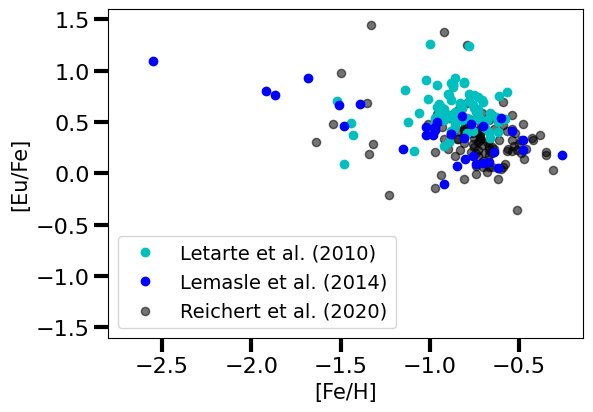

In [20]:
plot_A_ratios("Eu")

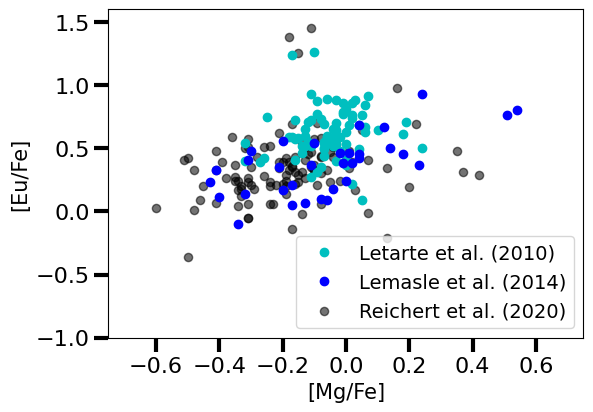

In [21]:
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis='[Mg/Fe]', yaxis=f'[Eu/Fe]')
plt.xlim(-0.75, 0.75)
plt.ylim(-1, 1.6)
plt.scatter(obs_df['[Mg/Fe]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')
plt.legend()

- What the axes mean  
    - Mg (an alpha element) traces core‑collapse SNe → prompt enrichment that follows star formation.  
    - Eu (mostly r‑process) traces rare/delayed sources (NS‑NS mergers or rare SNe) → timing/rate uncertain.  
    - Eu vs Mg therefore compares relative timescales and rarity of r‑process vs prompt CCSN enrichment.

- Signature motifs and their physical meaning  
    - Strong correlation (Eu rises with Mg): implies a prompt r‑process channel tied to massive stars.  
    - Decoupling (Mg high but Eu low, or Eu rises later): implies delayed r‑process sources (mergers) or low event rates.  
    - Large star‑to‑star scatter at low Mg (or low [Fe/H]): indicates stochastic enrichment from rare events and incomplete mixing in a low‑mass system.  
    - Systematic offset to lower [Mg/Fe] (at fixed [Fe/H]) compared to the Milky Way: indicates a slower/extended star‑formation history and earlier impact of SNe Ia.

- What the Fornax plot typically tells you (based on this dataset and common results)  
    - Fornax shows lower [Mg/Fe] than the Milky Way at the same [Fe/H] (alpha knee shifted to lower metallicity) → extended SFH, SNe Ia reduce alpha earlier.  
    - Eu in Fornax tends to rise later and/or shows larger scatter at low metallicity than MW → r‑process enrichment is relatively delayed or rarer (consistent with NS‑merger dominated r‑process or low overall merger rate).  
    - At higher metallicity Fornax may show increased s‑process signatures (Ba, La) from AGBs; Eu (r‑process) behavior remains sensitive to r‑process channels and their DTDs.

- How this differs from the Milky Way and other dwarfs  
    - Milky Way: faster early SF → higher alpha plateau, less stochastic scatter, and smoother Eu enrichment if a prompt channel contributes.  
    - Lower‑mass dwarfs: often show even larger scatter and more extreme stochastic signatures because of smaller gas reservoirs and fewer r‑process events. Fornax (more massive than many dSphs) is intermediate: smoother than ultra‑faint dwarfs but distinct from MW because of its extended SFH and gas flows.

- Implications for modelling / next checks (practical)  
    - The one‑zone smooth GCE you ran underpredicts early Eu rise — test: add a prompt r‑process channel, shorten DTDs, or include multiple r‑process channels.  
    - Run stochastic / inhomogeneous enrichment models (or Monte‑Carlo injections) to reproduce early‑time scatter.  
    - Overplot a Milky Way comparison sample and compute [Eu/Mg] vs [Fe/H] to isolate relative timing more clearly.  
    - Explore time‑dependent mass_loading and bursty SFH effects.

Short summary: Fornax’s Eu vs Mg pattern points to an extended star‑formation history plus delayed/rare r‑process enrichment (hence later Eu rise and larger low‑metallicity scatter) — different from the MW’s faster, smoother enrichment, and less extreme than the smallest dwarf galaxies.

## Fit Stellar Abundances with Models

In [91]:
# Define the galactic chemical evolution (GCE) parameters

# Dimensionless star formation efficiency (must be below 1.0)
# Original value --> 0.3
sfe = 0.3       

# Strength of galactic outflows (how much gas is removed from the galaxy)
# Original value --> 2.0
mass_loading = 2.0   

# Number of Type Ia supernova that occurs per stellar mass formed
# Original value --> 0.4e-3
nb_1a_per_m = 0.4e-3

agb_table = 'yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt'
Ia_table = 'yield_tables/sn1a_i99_W7.txt'

# ====================================
# ////////// Modify above ////////////

# Run the GCE code OMEGA
# Run the GCE code OMEGA
o_1 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, table = agb_table)

OMEGA run in progress..
..Time refinement..
   OMEGA run completed - Run time: 1.01s
   OMEGA run completed - Run time: 1.01s


In [92]:
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(o_1.nb_timesteps):
    m_star_lost += np.sum(o_1.mdot[i_t])

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(o_1.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 2.83E+07 Msun


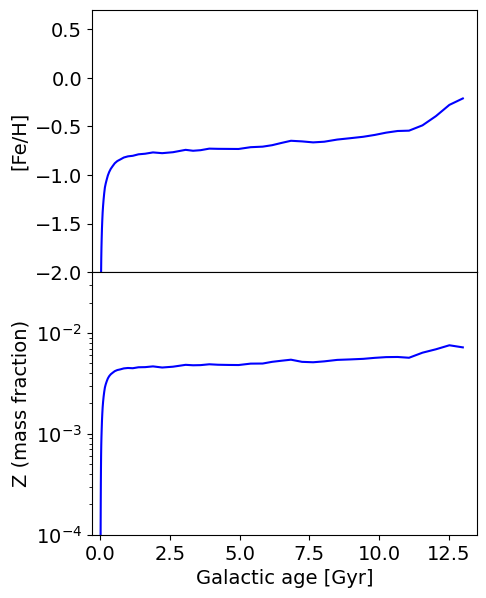

In [93]:
# Plot the age-metallicity relations
al_f = 14 # text font
matplotlib.rcParams.update({'font.size': 14.})
f, ax = plt.subplots(2,1, figsize=(5,7), sharex=True)
f.subplots_adjust(hspace=0)

# Extract predictions
o_t, o_Fe_H = o_1.plot_spectro(solar_norm='Asplund_et_al_2009', return_x_y=True)

# Plot age-[Fe/H]
# ===============

ax[0].plot(np.array(o_t)/1e9, o_Fe_H, '-b', linewidth=1.5)
ax[0].set_xlim(-0.3,13.5)
ax[0].set_ylim(-2., 0.7)

# Plot age-Z
# ==========
ax[1].plot(np.array(o_1.history.age)/1e9, o_1.history.metallicity, '-b', linewidth=1.5)
ax[1].set_yscale('log')
ax[1].set_xlim(-0.3,13.5)
ax[1].set_ylim(1e-4, 4e-2)

# Labels and visual aspect
#ax[0].legend(fontsize=16, loc=4, frameon=False)
ax[0].set_ylabel('[Fe/H]', fontsize=al_f)
ax[1].set_ylabel('Z (mass fraction)', fontsize=al_f)
ax[1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)

# Adjust layout/white spaces
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)
plt.subplots_adjust(right=0.97)

In [25]:
def plot_spectro_with_observations(model, yaxis = '[Eu/Fe]', xaxis = '[Fe/H]', ylim=None, xlim=None):
    """
    Plot the stellar abundances derived from observations
    and overplot the predictions from OMEGA+.

    Parameters
    ----------
    model : omega_plus.omega_plus object
        The OMEGA+ model object containing the predictions..
    """
    # Plot stellar abundances derived from observations
    matplotlib.rcParams.update({'font.size': 16.0})
    s.plot_spectro(galaxy="fornax", xaxis=xaxis, yaxis=yaxis)
    plt.scatter(obs_df[xaxis], obs_df[yaxis], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

    # Overplot the predictions on top of observations
    xy_0_1 = model.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
    plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
    plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction')

    # Update the legend and set the X and Y axis limits.
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
    if ylim and xlim:
        plt.ylim(ylim)
        plt.xlim(xlim)
    return

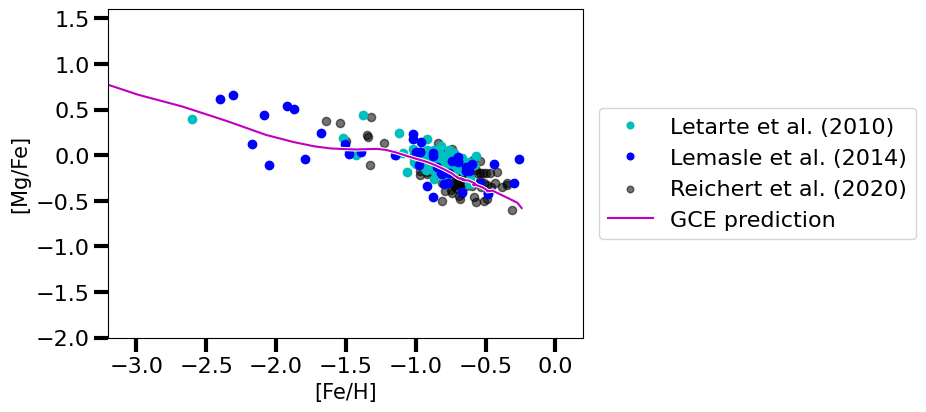

In [26]:
plot_spectro_with_observations(o_1, yaxis = '[Mg/Fe]', xaxis = '[Fe/H]', ylim=(-2, 1.6), xlim=(-3.2, 0.2))

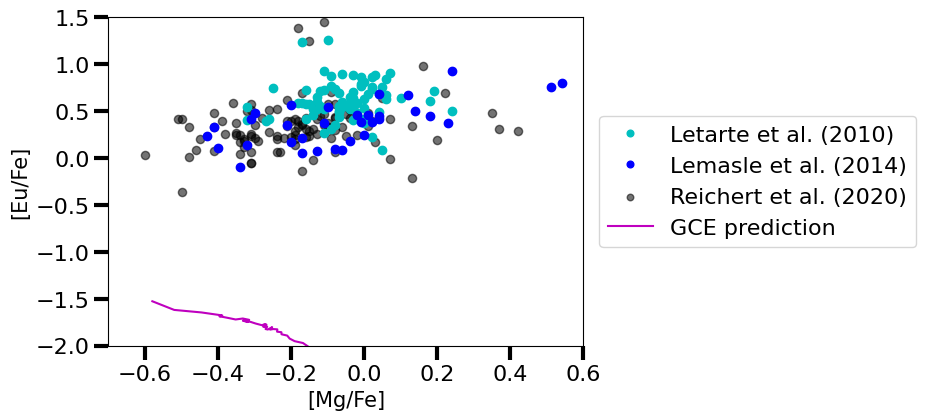

In [13]:
plot_spectro_with_observations(o_1, xaxis = '[Mg/Fe]', yaxis = '[Eu/Fe]', ylim=(-2, 1.5), xlim=(-0.7, 0.6))

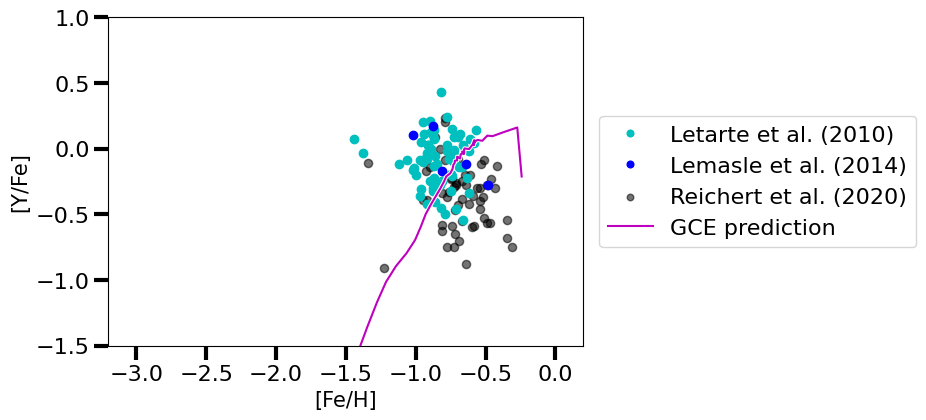

In [32]:
plot_spectro_with_observations(o_1, xaxis = '[Fe/H]', yaxis = '[Y/Fe]', ylim=(-1.5, 1), xlim=(-3.2, 0.2))

In [10]:
from stellab_utils import parse_stellab_file, ensure_abundance_columns

p1 = 'stellab_data/fornax_data/Letarte_et_al_2010_stellab.txt'
p2 = 'stellab_data/fornax_data/Lemasle_et_al_2014_stellab.txt'

df1 = parse_stellab_file(p1)
df2 = parse_stellab_file(p2)

# Ensure required [X/Fe] columns exist so plotting won't error
elements = ["Mg", "Sc", "Ti", "Cr", "Mn", "Ni", "Y", "Ba", "Eu"] #"Zn" (only 3 stars), "Sr" (0 stars)
ensure_abundance_columns(df1, elements)
ensure_abundance_columns(df2, elements)

# Optional: inspect the canonical columns
print('df1 columns ->', list(df1.columns))
print('df2 columns ->', list(df2.columns))

/home/minjih/NuPyCEE/stellab_utils.py:86: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment="#", header=0, engine="python")
/home/minjih/NuPyCEE/stellab_utils.py:86: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment="#", header=0, engine="python")


df1 columns -> ['[Na/Fe]', 'err', '[Mg/Fe]', 'err_1', '[Si/Fe]', 'err_2', '[Ca/Fe]', 'err_3', '[Ti/Fe]', 'err_4', '[Ti2/Fe]', 'err_5', '[Cr/Fe]', 'err_6', '[Fe/H]', 'err_7', '[Fe2/H]', 'err_8', '[Ni/Fe]', 'err_9', '[Y/Fe]', 'err_10', '[Ba/Fe]', 'err_11', '[La/Fe]', 'err_12', '[Nd/Fe]', 'err_13', '[Eu/Fe]', 'err_14', '[Fe2/Fe]', '[Sc/Fe]', '[Mn/Fe]']
df2 columns -> ['[Fe/H]', 'err', '[FeII/H]', 'err_1', '[Na/H]', 'err_2', '[Mg/H]', 'err_3', '[Si/H]', 'err_4', '[Ca/H]', 'err_5', '[Sc/H]', 'err_6', '[Ti/H]', 'err_7', '[TiII/H]', 'err_8', '[Cr/H]', 'err_9', '[Ni/H]', 'err_10', '[Y/H]', 'err_11', '[Ba/H]', 'err_12', '[La/H]', 'err_13', '[Nd/H]', 'err_14', '[Eu/H]', 'err_15', '[FeII/Fe]', '[Na/Fe]', '[Mg/Fe]', '[Si/Fe]', '[Ca/Fe]', '[Sc/Fe]', '[Ti/Fe]', '[TiII/Fe]', '[Cr/Fe]', '[Ni/Fe]', '[Y/Fe]', '[Ba/Fe]', '[La/Fe]', '[Nd/Fe]', '[Eu/Fe]', '[Mn/Fe]']


In [94]:
def plot_grid(model):
    ncols = 3
    nplots = len(elements)
    nrows = math.ceil(nplots / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows), sharex=True)
    axes = axes.flatten()

    # Optional per-element y-limits (tune as you like)
    ylim_dict = {
        'Eu': (-2.0, 2.0),
        'Mg': (-1.0, 1.0),
        'Ba': (-1.5, 1.5),
        'Sc': (-1.5, 1.0),
        'Ti': (-1.5, 1.0),
        'Cr': (-1.5, 1.0),
        'Mn': (-1.5, 0.5),
        'Ni': (-1, 1.5),
        'Y': (-1.5, 1.0),
    }

    # Plot each element into its subplot but do NOT draw per-axis legends
    for i, elem in enumerate(elements):
        ax = axes[i]
        plt.sca(ax)  # make this subplot the current axes so the called function plots into it

        yaxis = f'[{elem}/Fe]'

        # Plot stellar abundances derived from observations (labels retained for global legend)
        matplotlib.rcParams.update({'font.size': 16.0})
        ax.scatter(df1['[Fe/H]'], df1[yaxis], s=35, label='Letarte et al. (2010)', color='blue')
        ax.scatter(df2['[Fe/H]'], df2[yaxis], s=35, label='Lemasle et al. (2014)', color='lightblue')
        ax.scatter(obs_df['[Fe/H]'], obs_df[yaxis], s=35, alpha=0.55, label='Reichert et al. (2020)', color='green')

        # Overplot the predictions on top of observations
        xy_0_1 = model.plot_spectro(xaxis='[Fe/H]', yaxis=yaxis, return_x_y=True)
        ax.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
        ax.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction')

        # Do not call ax.legend() here (we will create a single global legend)

        ax.set_xlim(-3.2, 0.2)
        ax.set_ylim(ylim_dict.get(elem, None))

        ax.set_title(elem)
        # y-label only on left column
        if i % ncols == 0:
            ax.set_ylabel(yaxis)
        # x-label only on bottom row
        if i // ncols == nrows - 1:
            ax.set_xlabel('[Fe/H]')

    # Remove empty subplots (if any)
    for j in range(nplots, nrows * ncols):
        fig.delaxes(axes[j])

    # Adjust layout to make room on the right for a global legend
    fig.subplots_adjust(right=0.78)

    # Collect unique legend entries from all axes (preserve order)
    all_handles = []
    all_labels = []
    for ax in axes[:nplots]:
        h, l = ax.get_legend_handles_labels()
        all_handles.extend(h)
        all_labels.extend(l)

    # Keep only the first occurrence of each label
    unique = {}
    for handle, label in zip(all_handles, all_labels):
        if label not in unique:
            unique[label] = handle

    unique_labels = list(unique.keys())
    unique_handles = [unique[lbl] for lbl in unique_labels]

    # Place a single legend on the right side in the empty space
    fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(0.995, 0.5), fontsize=10)

    fig.tight_layout()
    plt.show()

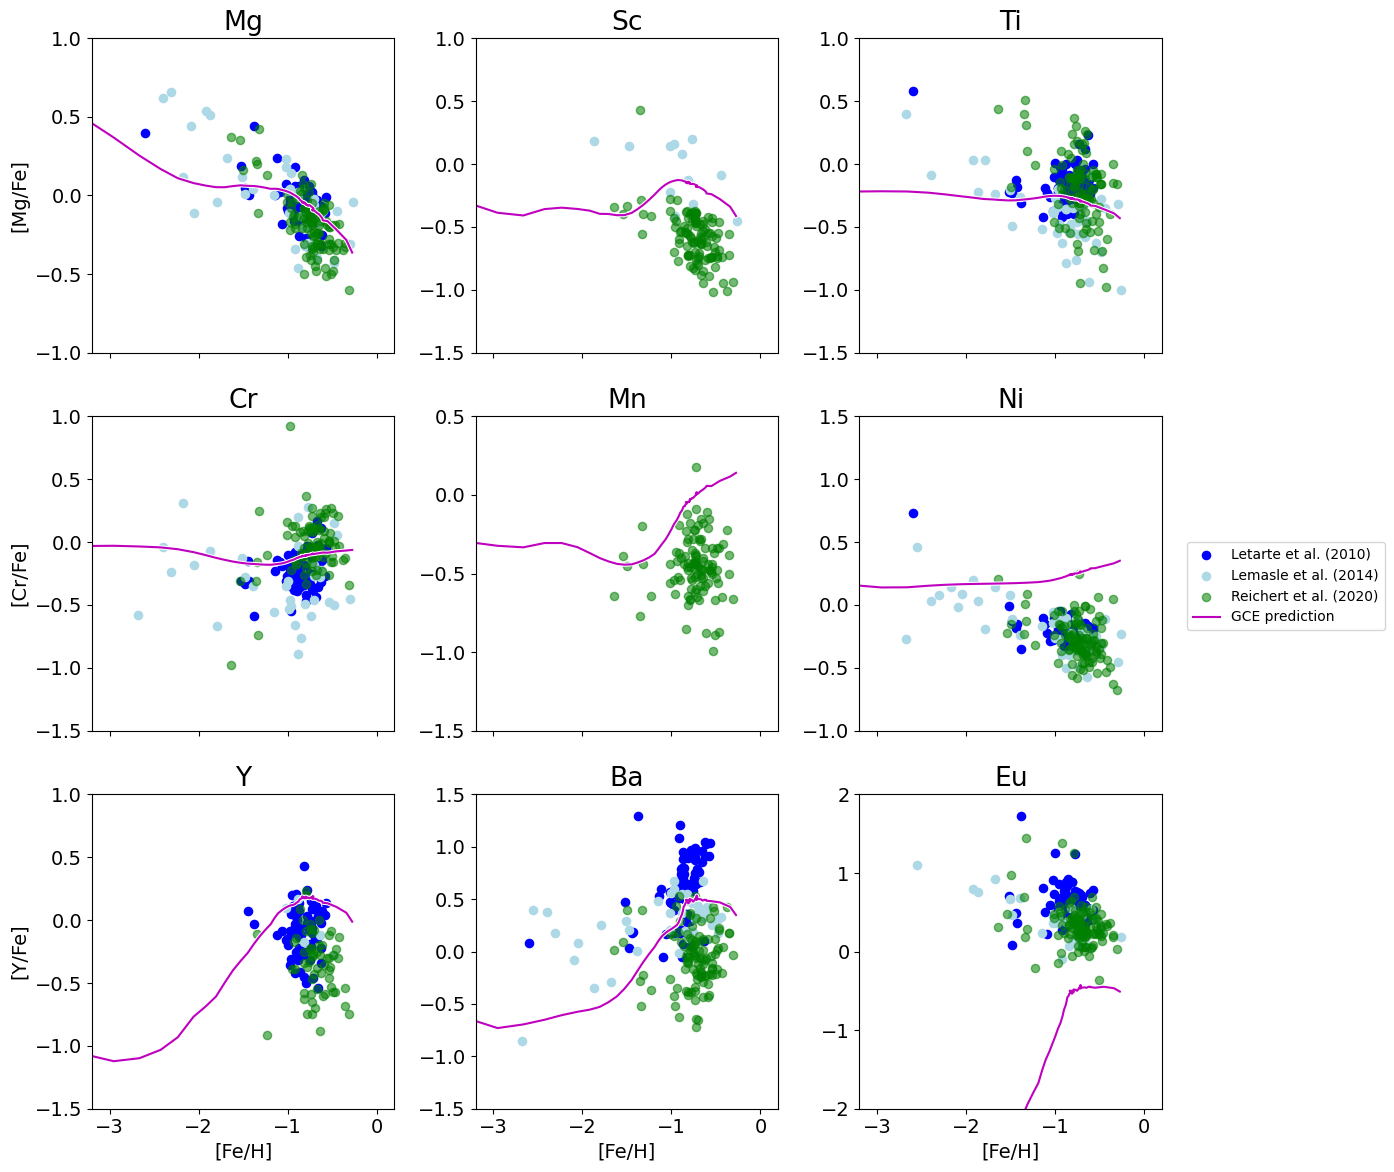

In [95]:
plot_grid(o_1)

### Baseline
- default yield tables
- r_process_rosswog_2014 (NSM)

Prediction is not universal across different elements, e.g. above works well for Mg but not for e.g. Ba, Eu. 

- Mg is an alpha element produced rapidly and copiously by core-collapse SNe, so its evolution closely traces the star-formation history and is relatively easy to match with smooth one‑zone models. The massive-star yields + IMF/SFE chosen give early Mg plateau.
- Overpredicts Fe-peak elements Ti, Cr, Mn, Ni (Ni is worst). Uncertainties in CCSN vs. SNe Ia yields and metallicity dependence; the SN Ia yield table (and fraction / channel mix) strongly controls Mn/Ni/Cr.
- Y, Sr (light n-capture / weak-s/weak-r): large scatter/poor match because they come from multiple channels (weak s in rotating massive stars, weak r or charged-particle processes, AGB weak s) — one-zone smooth models cannot capture the local stochasticity or missing channels.
- Eu (r-process): shows NSM alone is not enough
- Ba (s-process): Ba is mainly produced by the main s-process in low-to-intermediate mass AGB stars — a delayed contribution (hundreds of Myr → Gyr). AGB (s-process) contribution or its delay is insufficient, or because the model SFH/metallicity evolution mis-times the AGB contribution.


### many fixed by using Cristallo table

# Add MRD yield

In [18]:
mrd_table = repo_root / "yield_tables" / "additional_sources" / "L0.75.dat"

# Parse L0.75.dat to extract isotope names and masses (in Msun)
# File format: each line has 'name Z N A X' where X is mass fraction
# Total ejecta mass is read from the header (line 4)

# Read total ejecta mass from header
total_ejecta_msun = None
with open(mrd_table, 'r') as f:
    for line in f:
        if 'Total ejecta:' in line:
            # Extract the mass value from the header line
            parts = line.split()
            total_ejecta_msun = float(parts[3])
            break

if total_ejecta_msun is None:
    raise ValueError("Could not find 'Total ejecta:' in header of L0.75.dat")

# Parse isotope data
isotope_names = []
mrd_masses = []

with open(mrd_table, 'r') as f:
    for line in f:
        # Skip comment lines and empty lines
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        
        # Parse the data line: name Z N A X [Y]
        parts = line.split()
        if len(parts) < 5:
            continue
        
        iso_name = parts[0]
        Z = int(parts[1])
        N = int(parts[2])
        A = int(parts[3])
        X = float(parts[4])  # mass fraction
        
        # Convert isotope name to format: 'Element-A' (e.g., 'H-1', 'He-4', 'C-12')
        # Use Z and A to construct the name
        element_map = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O',
                      9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P',
                      16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K', 20: 'Ca', 21: 'Sc', 22: 'Ti',
                      23: 'V', 24: 'Cr', 25: 'Mn', 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu',
                      30: 'Zn', 31: 'Ga', 32: 'Ge', 33: 'As', 34: 'Se', 35: 'Br', 36: 'Kr',
                      37: 'Rb', 38: 'Sr', 39: 'Y', 40: 'Zr', 41: 'Nb', 42: 'Mo', 43: 'Tc',
                      44: 'Ru', 45: 'Rh', 46: 'Pd', 47: 'Ag', 48: 'Cd', 49: 'In', 50: 'Sn',
                      51: 'Sb', 52: 'Te', 53: 'I', 54: 'Xe', 55: 'Cs', 56: 'Ba', 57: 'La',
                      58: 'Ce', 59: 'Pr', 60: 'Nd', 61: 'Pm', 62: 'Sm', 63: 'Eu', 64: 'Gd',
                      65: 'Tb', 66: 'Dy', 67: 'Ho', 68: 'Er', 69: 'Tm', 70: 'Yb', 71: 'Lu',
                      72: 'Hf', 73: 'Ta', 74: 'W', 75: 'Re', 76: 'Os', 77: 'Ir', 78: 'Pt',
                      79: 'Au', 80: 'Hg', 81: 'Tl', 82: 'Pb', 83: 'Bi', 84: 'Po', 85: 'At',
                      86: 'Rn', 87: 'Fr', 88: 'Ra', 89: 'Ac', 90: 'Th', 91: 'Pa', 92: 'U'}
        
        element = element_map.get(Z, f'Z{Z}')
        isotope_name = f'{element}-{A}'
        
        # Convert mass fraction to mass in Msun
        mass_msun = X * total_ejecta_msun
        
        isotope_names.append(isotope_name)
        mrd_masses.append(mass_msun)

# Store as dictionary and print summary
mrd_data = dict(zip(isotope_names, mrd_masses))
print(f"Loaded {len(mrd_data)} isotopes from L0.75.dat")
print(f"Total ejecta mass: {total_ejecta_msun:.6e} Msun")

Loaded 286 isotopes from L0.75.dat
Total ejecta mass: 2.004670e-01 Msun


In [27]:
formatted_mrd_yield = []
for i in range(len(o_1.history.isotopes)):
    try: 
        get = mrd_data[o_1.history.isotopes[i]]
        formatted_mrd_yield.append(get)
    except Exception:
        formatted_mrd_yield.append(0)
formatted_mrd_yield = np.array(formatted_mrd_yield)

In [100]:
# Create a modified version of o_1 by manually adding MRD yields at prompt window
# Use the same parameters as o_1 but with external_control to allow m_added parameter
o_ext = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                    nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, \
                    table = agb_table, external_control=True)

prompt_window = (0.0, 3.0e7)

# Manually evolve o_ext by copying o_1's timesteps, adding MRD when in the prompt window
# Iterate through all valid timesteps (0 to nb_timesteps-2) to avoid out-of-bounds on ymgal access
for i_t in range(o_1.nb_timesteps - 1):
    sfr = o_1.history.sfr_abs[i_t]
    age = o_1.history.age[i_t]
    
    # Determine if we should add MRD yields
    add_mrd = (age >= prompt_window[0] and age <= prompt_window[1])
    
    # Call run_step with i_t+1 (omega uses 1-indexed steps internally)
    if add_mrd:
        # During prompt window: add MRD yields
        m_added = o_ext.ymgal[i_t] + formatted_mrd_yield
        o_ext.run_step(i_t + 1, sfr, m_added=m_added)
    else:
        # Outside prompt window: standard evolution
        o_ext.run_step(i_t + 1, sfr)

# Run the final step without MRD (outside prompt window by definition at end of simulation)
# This populates the last ymgal row so plot_spectro won't return all zeros
if o_1.nb_timesteps - 1 < len(o_1.history.sfr_abs):
    o_ext.run_step(o_1.nb_timesteps, o_1.history.sfr_abs[o_1.nb_timesteps - 1])

OMEGA run in progress..
..Time refinement..
Warning - Negative inflow.  The outflow rate has been increased. 1
Warning - Negative inflow.  The outflow rate has been increased. 2
Warning - Negative inflow.  The outflow rate has been increased. 3
Warning - Negative inflow.  The outflow rate has been increased. 4
Warning - Negative inflow.  The outflow rate has been increased. 5
Warning - Negative inflow.  The outflow rate has been increased. 6
Warning - Negative inflow.  The outflow rate has been increased. 7
Warning - Negative inflow.  The outflow rate has been increased. 8
Warning - Negative inflow.  The outflow rate has been increased. 9
Warning - Negative inflow.  The outflow rate has been increased. 10
Warning - Negative inflow.  The outflow rate has been increased. 11
Warning - Negative inflow.  The outflow rate has been increased. 12
Warning - Negative inflow.  The outflow rate has been increased. 13
Warning - Negative inflow.  The outflow rate has been increased. 14
Warning - Neg

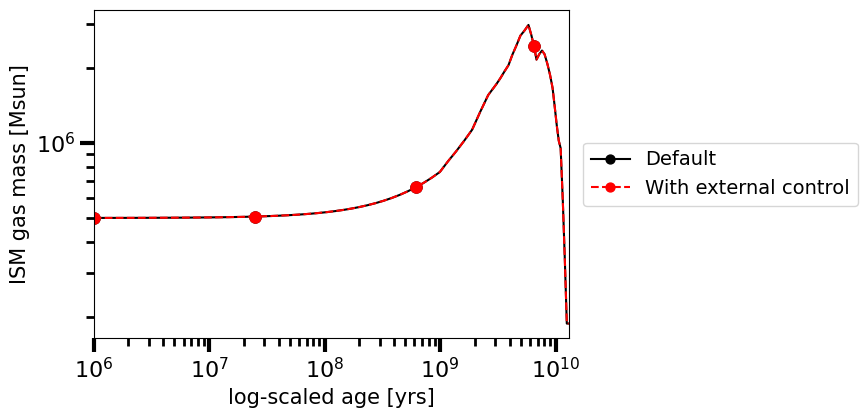

In [101]:
# Plot the different amount of gas inside the galaxy
o_1.plot_totmasses(color='k', label='Default')
o_ext.plot_totmasses(color='r', shape='--', label='With external control')

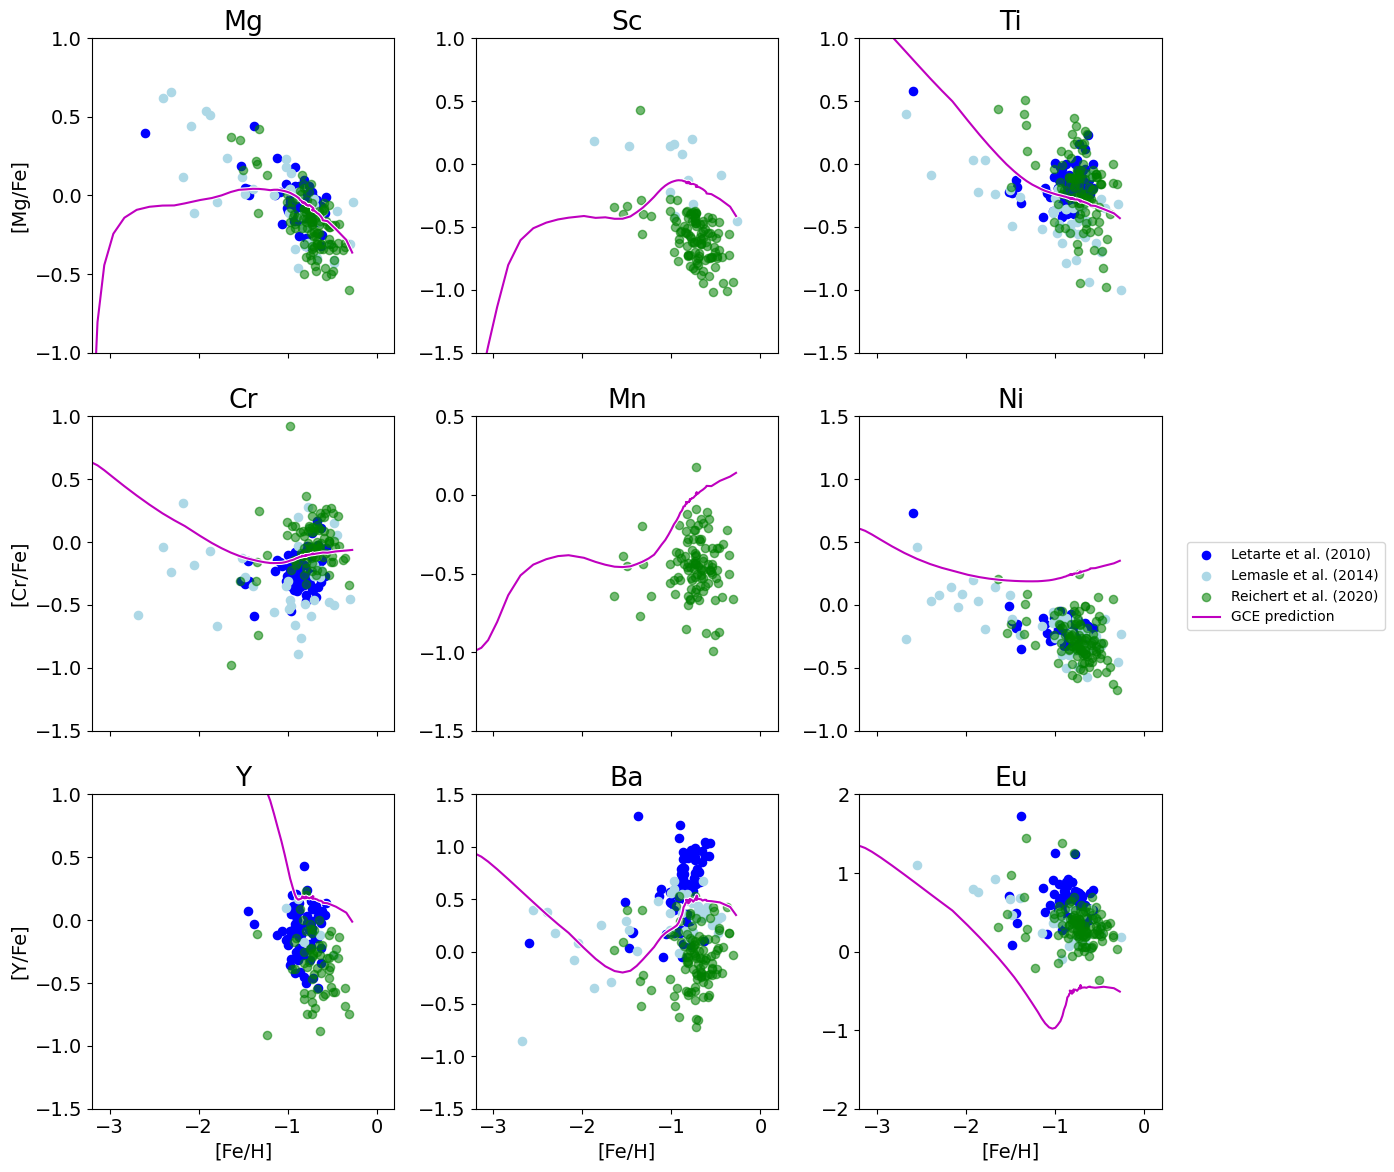

In [102]:
plot_grid(o_ext)

## Trying to adjust baseline model

In [ ]:
# Define the galactic chemical evolution (GCE) parameters

# Dimensionless star formation efficiency (must be below 1.0)
# Original value --> 0.3
sfe = 0.99         

# Strength of galactic outflows
# Original value --> 2.0
mass_loading = 0.01

# Number of Type Ia supernova that occurs per stellar mass formed
# Original value --> 0.4e-3
nb_1a_per_m = 0.01e-3

# ====================================
# ////////// Modify above ////////////

# Run the GCE code OMEGA
o_2 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0)

OMEGA run in progress..
..Time refinement..
Warning - Negative inflow.  The outflow rate has been increased. 133
Warning - Negative inflow.  The outflow rate has been increased. 134
Warning - Negative inflow.  The outflow rate has been increased. 135
Warning - Negative inflow.  The outflow rate has been increased. 136
   OMEGA run completed - Run time: 2.24s


(-3.2, 0.2)

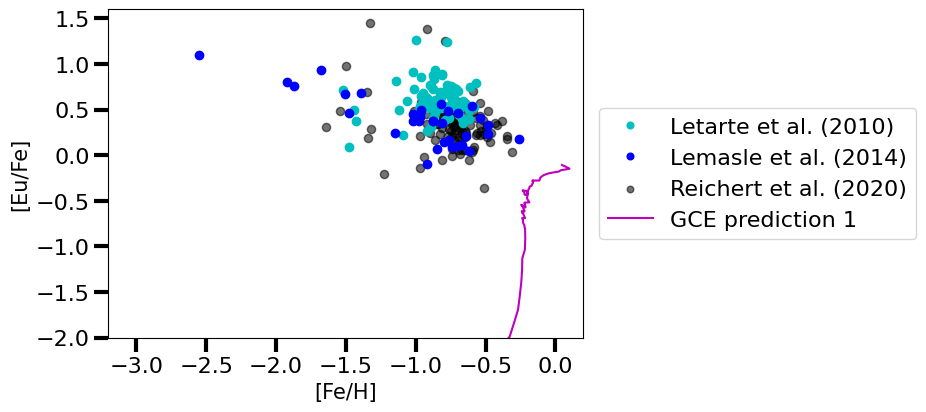

In [ ]:
# Choose your elemental abundance ratios
yaxis = '[Eu/Fe]'
xaxis = '[Fe/H]'

# Plot stellar abundances derived from observations
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis=xaxis, yaxis=yaxis)
plt.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

# Overplot the predictions on top of observations
xy_0_1 = o_2.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction 1')

# Update the legend and set the X and Y axis limits.
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
plt.ylim(-2, 1.6)
plt.xlim(-3.2, 0.2)

(-0.7, 0.5)

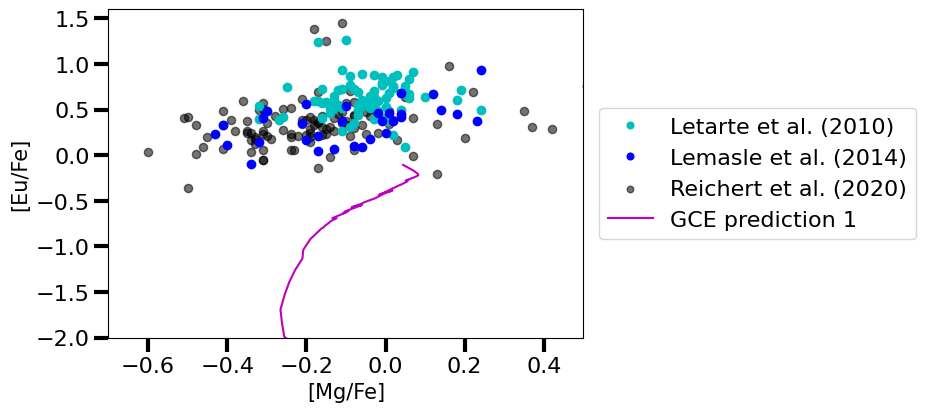

In [ ]:
# Choose your elemental abundance ratios
xaxis = '[Mg/Fe]'
yaxis = '[Eu/Fe]'

# Plot stellar abundances derived from observations
matplotlib.rcParams.update({'font.size': 16.0})
s.plot_spectro(galaxy=galaxy, xaxis=xaxis, yaxis=yaxis)
plt.scatter(obs_df['[Mg/Fe]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

# Overplot the predictions on top of observations
xy_0_1 = o_2.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction 1')

# Update the legend and set the X and Y axis limits.
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
plt.ylim(-2, 1.6)
plt.xlim(-0.7, 0.5)

Currently, the prediction increases only up to ~0 in [Eu/Fe] at the end of the simulation. It should increase earlier and more, but not possible to do so with current configuration, this shows that GCE needs:

- Shorter/modified DTDs or a prompt component for some r‑process sources to produce earlier Eu enrichment.
- Metallicity‑dependent yields and alternative yield sets for massive stars, AGBs and r‑process sites.
- Explicit AGB (s‑process) contributions with realistic delay times to separate r‑ and s‑process evolution.
- Multiple r‑process channels (NS‑NS mergers, NS‑BH, magnetorotational/jet SNe, collapsars) with separate yields, rates and delay‑time distributions (DTDs).

and, possibly:
- Inhomogeneous / non‑instantaneous mixing (multi‑zone or sub‑grid mixing length) instead of one‑zone instantaneous mixing.
- Stochastic, discrete enrichment events (Monte‑Carlo injections) for rare r‑process sources so early-time scatter and sporadic enrichments are captured.
- Time‑dependent, bursty star‑formation histories and variable inflow/outflow prescriptions (mass_loading as a function of time or mass).
- Parameter uncertainties: run ensembles to explore parameter space (mass_loading, sfe, nb_1a_per_m, yields, DTDs) and derive confidence bands.